# Simulation

In [1]:
!pip install qutip qutip-qip qutip-qtrl sympy tensorflow

In [2]:
from qutip import *
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-04-25 17:02:44.931618: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 17:02:44.935553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 17:02:44.978591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 17:02:44.978627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 17:02:44.978697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
ket_0 = basis(2, 0) #|0>
ket_1 = basis(2, 1) #|1>

# Bell state phi_plus = (|00>+|11>)/sqrt(2)
phi_plus = (tensor(ket_0, ket_0) + tensor(ket_1, ket_1)).unit()
# Bell state phi_minus = (|00> - |11>)/sqrt(2)
phi_minus = (tensor(ket_0, ket_0) - tensor(ket_1, ket_1)).unit()
# Bell state psi_plus = (|01>+|10>)/sqrt(2)
psi_plus = (tensor(ket_0, ket_1) + tensor(ket_1, ket_0)).unit()
# Bell state psi_minus = (|01>-|10>)/sqrt(2)
psi_minus = (tensor(ket_0, ket_1) - tensor(ket_1, ket_0)).unit()

bell_states = {"phi_plus" : phi_plus, 
          "phi_minus": phi_minus, 
          "psi_plus": psi_plus, 
          "psi_minus": psi_minus}

In [4]:
def is_entangled_chsh(state):
    A_1 = sigmaz()
    A_2 = sigmax()
    B_1 = (sigmaz() + sigmax()) / np.sqrt(2)
    B_2 = (sigmaz() - sigmax()) / np.sqrt(2)
    CHSH_ZX = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmay()
    A_2 = sigmaz()
    B_1 = (sigmay() + sigmaz()) / np.sqrt(2)
    B_2 = (sigmay() - sigmaz()) / np.sqrt(2)
    CHSH_YZ = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmax()
    A_2 = sigmay()
    B_1 = (sigmax() + sigmay()) / np.sqrt(2)
    B_2 = (sigmax() - sigmay()) / np.sqrt(2)
    CHSH_XY = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    chsh_operators ={"CHSH_ZX": CHSH_ZX, "CHSH_YZ": CHSH_YZ, "CHSH_XY": CHSH_XY}

    for chsh_basis, chsh_operator in chsh_operators.items():
        violation = np.abs(state.dag() * chsh_operator * state)
        if violation > 2:
            return True
    return False

In [5]:
def is_entangled_concurrence(state):
    state_dm = state * state.dag() 
    conc = concurrence(state_dm)
    return conc != 0.0

In [6]:
def is_entangled_entropy(state):
    state_dm = state * state.dag() 
    ptrace = state_dm.ptrace(0) 
    entropy = entropy_vn(ptrace, base=2)
    return entropy != 0

In [7]:
def is_entangled_negativity(state):
    state_dm = state * state.dag()
    neg = (partial_transpose(state_dm, [0, 1]).eigenenergies() < 0).sum()
    return neg != 0

In [8]:
def get_simulated_training_data(entanglement_witness):
    samples_nb = 2000
    samples_states = []
    samples_entangled = []
    
    for _ in range(0, samples_nb):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 0)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 1)))
        samples_states.append(state)
        samples_entangled.append(is_entangled_chsh(state))
    
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 1)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 0)))
        samples_states.append(state)
        samples_entangled.append(is_entangled_chsh(state))
    
        state = tensor(rand_ket(2), rand_ket(2))
        samples_states.append(state)
        samples_entangled.append(entanglement_witness(state))

    return samples_states, samples_entangled

In [9]:
def get_model(samples_states, samples_entangled):
    data = np.array([np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]) for state in samples_states])
    labels = np.array(samples_entangled)     

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data.shape[1],)),  # Adjust input shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    model.evaluate(X_val, y_val)

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model

MODEL FOR ENTANGLEMENT WITNESS CHSH
Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.5135 - accuracy: 0.7529 - val_loss: 0.4746 - val_accuracy: 0.7367
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.3924 - accuracy: 0.8167 - val_loss: 0.3562 - val_accuracy: 0.8600
Epoch 3/10
150/150 [==============================] - 0s 1ms/step - loss: 0.3003 - accuracy: 0.8821 - val_loss: 0.2920 - val_accuracy: 0.8608
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9050 - val_loss: 0.2222 - val_accuracy: 0.9075
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1823 - accuracy: 0.9358 - val_loss: 0.1665 - val_accuracy: 0.9400
Epoch 6/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1437 - accuracy: 0.9565 - val_loss: 0.1451 - val_accuracy: 0.9483
Epoch 7/10
150/150 [==============================] - 0s 3ms/step - loss: 0.1212 - accuracy: 0.9635 - val_loss: 

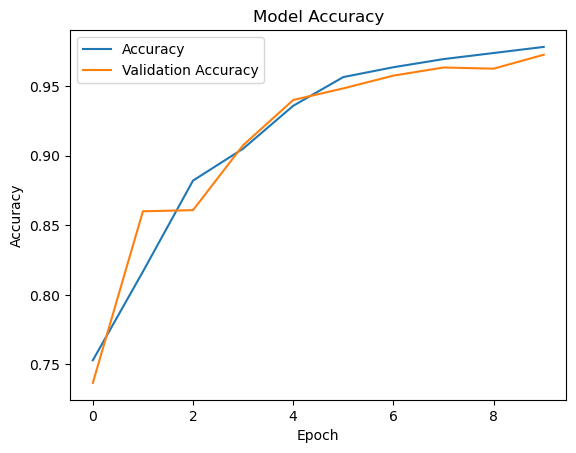

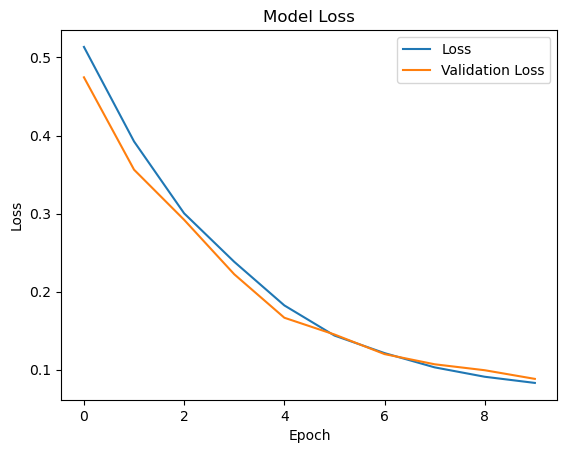

MODEL FOR ENTANGLEMENT WITNESS CONCURRENCE
Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.5407 - accuracy: 0.7342 - val_loss: 0.4772 - val_accuracy: 0.7425
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8077 - val_loss: 0.3602 - val_accuracy: 0.8583
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8825 - val_loss: 0.2812 - val_accuracy: 0.8992
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9127 - val_loss: 0.2166 - val_accuracy: 0.9217
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.9388 - val_loss: 0.1739 - val_accuracy: 0.9600
Epoch 6/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1595 - accuracy: 0.9588 - val_loss: 0.1411 - val_accuracy: 0.9508
Epoch 7/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1359 - accuracy: 0.9673 - val

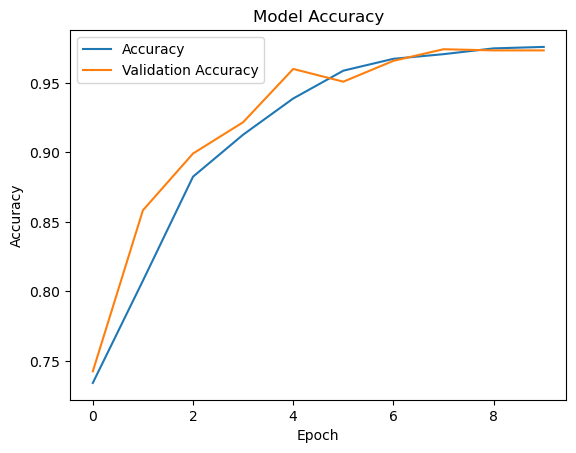

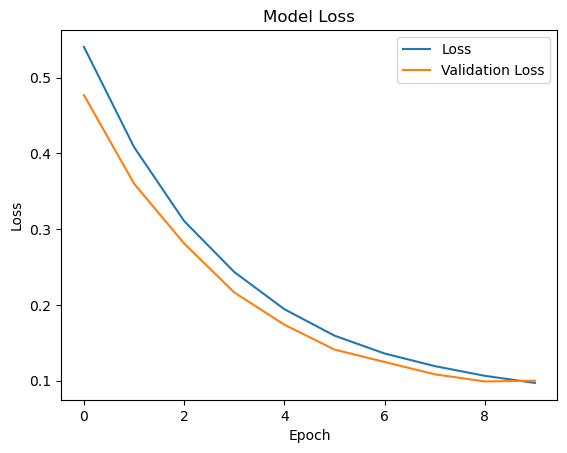

MODEL FOR ENTANGLEMENT WITNESS ENTROPY
Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.6143 - accuracy: 0.6835 - val_loss: 0.5249 - val_accuracy: 0.8283
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.8398 - val_loss: 0.4056 - val_accuracy: 0.8425
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8579 - val_loss: 0.3617 - val_accuracy: 0.8525
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.8783 - val_loss: 0.3258 - val_accuracy: 0.8650
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.9025 - val_loss: 0.2904 - val_accuracy: 0.9008
Epoch 6/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2472 - accuracy: 0.9229 - val_loss: 0.2712 - val_accuracy: 0.9225
Epoch 7/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2249 - accuracy: 0.9390 - val_los

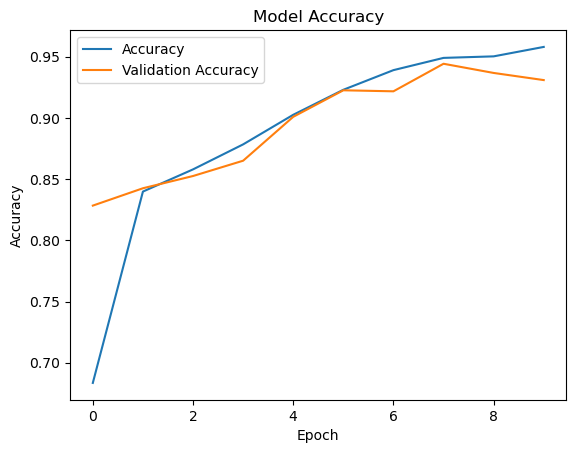

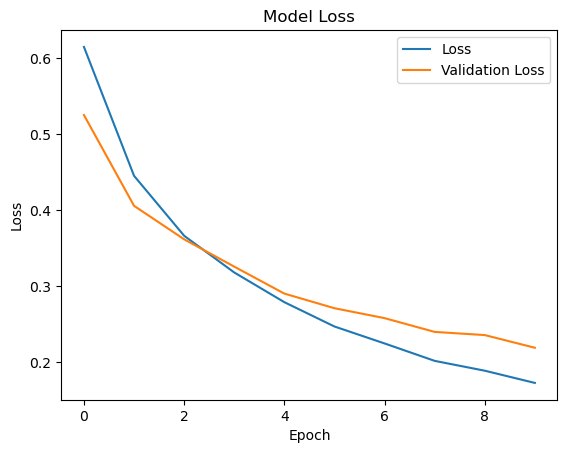

MODEL FOR ENTANGLEMENT WITNESS NEGATIVITY
Epoch 1/10
150/150 [==============================] - 1s 2ms/step - loss: 0.6221 - accuracy: 0.6656 - val_loss: 0.5347 - val_accuracy: 0.7842
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.4500 - accuracy: 0.8438 - val_loss: 0.3770 - val_accuracy: 0.8517
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.8704 - val_loss: 0.2968 - val_accuracy: 0.8750
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.8908 - val_loss: 0.2448 - val_accuracy: 0.9075
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 0.9200 - val_loss: 0.1975 - val_accuracy: 0.9350
Epoch 6/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9442 - val_loss: 0.1666 - val_accuracy: 0.9492
Epoch 7/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9533 - val_

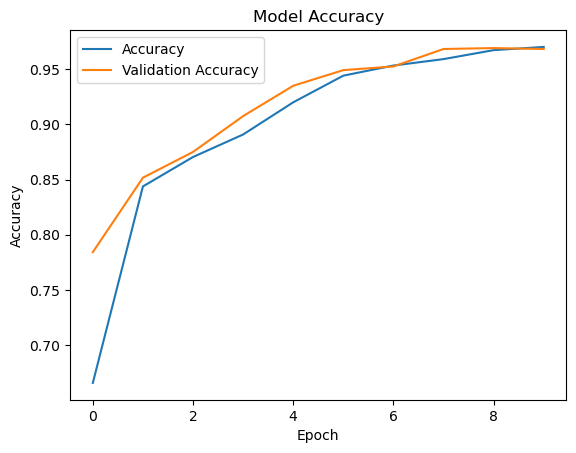

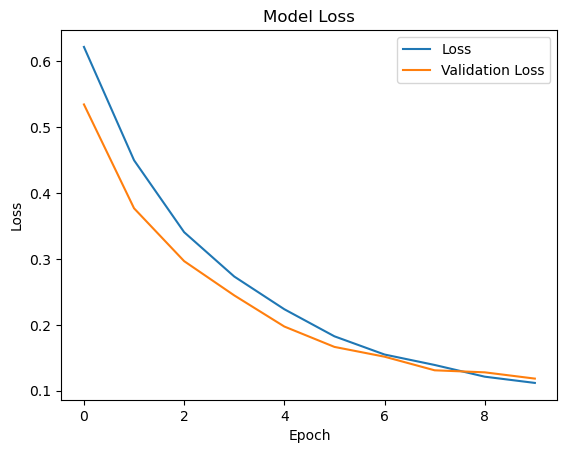

In [10]:
entanglement_witnesses = {"CHSH": is_entangled_chsh, "CONCURRENCE": is_entangled_concurrence, "ENTROPY": is_entangled_entropy, "NEGATIVITY": is_entangled_negativity}
models = {}

for name, witness in entanglement_witnesses.items():
    print("MODEL FOR ENTANGLEMENT WITNESS", name)
    samples_states, samples_entangled =  get_simulated_training_data(witness)
    model = get_model(samples_states, samples_entangled)
    models[name] = {"model": model, "witness": witness}


In [11]:
for name, model_data in models.items():
    model = model_data["model"]
    witness = model_data["witness"]
    
    print("TESTS FOR MODEL", name)
    
    for state_name, state in bell_states.items():
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state_name, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))
    
    for _ in range(0, 4):
        state = tensor(rand_ket(2), rand_ket(2))
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))

TESTS FOR MODEL CHSH
1/1 [==============================] - 0s 96ms/step
Predicted probability of phi_plus being entangled: 0.9996757507324219
Is the state entangled [is_entangled_chsh]:  True
1/1 [==============================] - 0s 17ms/step
Predicted probability of phi_minus being entangled: 0.9984917640686035
Is the state entangled [is_entangled_chsh]:  True
1/1 [==============================] - 0s 16ms/step
Predicted probability of psi_plus being entangled: 0.9767888188362122
Is the state entangled [is_entangled_chsh]:  True
1/1 [==============================] - 0s 14ms/step
Predicted probability of psi_minus being entangled: 0.9997033476829529
Is the state entangled [is_entangled_chsh]:  True
1/1 [==============================] - 0s 20ms/step
Predicted probability of Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.05056772-0.0454746j ]
 [0.20074192-0.11256039j]
 [0.15107648+0.22990752j]
 [0.32794599+0.87130802j]] being entangled: 6